In [3]:
# Mohammad Salem 1200651
print("test Connections ...\nMohammad Salem 1200651\n")

test Connections ...
Mohammad Salem 1200651



In [5]:
#  Assignment 2: Setup
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 1) Reproducibility
torch.manual_seed(0)

# 2) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3) Hyper-parameters
batch_size    = 128
num_epochs    = 10
learning_rate = 1e-3

# 4) Data transforms
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 5) Datasets
mnist_train = datasets.MNIST(root='data', train=True,  download=True, transform=mnist_transform)
mnist_test  = datasets.MNIST(root='data', train=False, download=True, transform=mnist_transform)
cifar_train = datasets.CIFAR10(root='data', train=True,  download=True, transform=cifar_transform)
cifar_test  = datasets.CIFAR10(root='data', train=False, download=True, transform=cifar_transform)

# 6) DataLoaders
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test,  batch_size=batch_size, shuffle=False)
cifar_train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_test_loader  = DataLoader(cifar_test,  batch_size=batch_size, shuffle=False)

# 7)  check shapes
imgs, labels = next(iter(mnist_train_loader))
print(f"MNIST batch shape: {imgs.shape} → labels: {labels.shape}")
###########
imgs, labels = next(iter(cifar_train_loader))
print(f"CIFAR-10 batch shape: {imgs.shape} → labels: {labels.shape}")




Using device: cuda
MNIST batch shape: torch.Size([128, 1, 28, 28]) → labels: torch.Size([128])
CIFAR-10 batch shape: torch.Size([128, 3, 32, 32]) → labels: torch.Size([128])


# A little  sample from MNIST and CIFER10 Data set

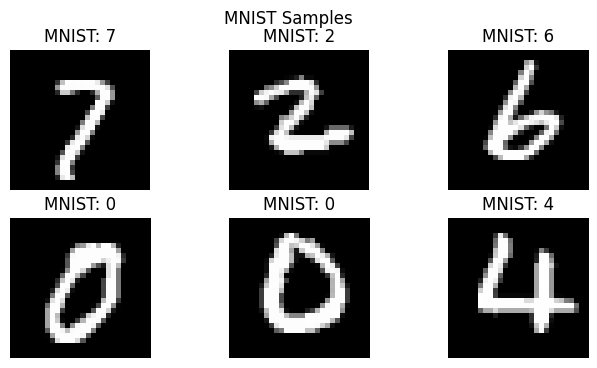

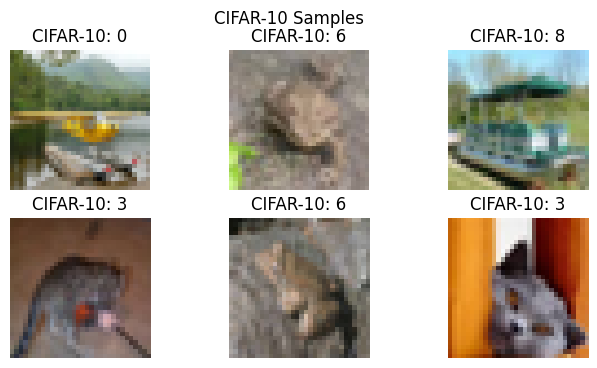

In [7]:
import matplotlib.pyplot as plt

# Helper to unnormalize an image tensor (–1→1 back to 0→1)
def unnormalize(img):
    return img * 0.5 + 0.5

# Grab a batch from each loader
mnist_imgs, mnist_labels = next(iter(mnist_train_loader))
cifar_imgs, cifar_labels = next(iter(cifar_train_loader))

# Plot 6 MNIST samples
fig = plt.figure(figsize=(8,4))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    img = mnist_imgs[i].squeeze(0)           # shape: (28,28)
    img = unnormalize(img).numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"MNIST: {mnist_labels[i].item()}")
    ax.axis('off')
plt.suptitle("MNIST Samples")
plt.show()

# Plot 6 CIFAR-10 samples
fig = plt.figure(figsize=(8,4))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    img = cifar_imgs[i]                     # shape: (3,32,32)
    img = unnormalize(img).permute(1,2,0).numpy()
    ax.imshow(img)
    ax.set_title(f"CIFAR-10: {cifar_labels[i].item()}")
    ax.axis('off')
plt.suptitle("CIFAR-10 Samples")
plt.show()


# Architecture A – CNN Baselin

In [8]:
# Step 2: Define SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, img_size):
        super(SimpleCNN, self).__init__()
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),  # (C, H, W) → (32, H, W)
            nn.ReLU(),
            nn.MaxPool2d(2),                                       # → (32, H/2, W/2)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),           # → (64, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(2),                                       # → (64, H/4, W/4)
        )
        # Compute flattened feature size dynamically
        feat_dim = 64 * (img_size // 4) * (img_size // 4)
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate for MNIST (1×28×28) and CIFAR-10 (3×32×32)
cnn_mnist = SimpleCNN(in_channels=1, num_classes=10, img_size=28).to(device)
cnn_cifar = SimpleCNN(in_channels=3, num_classes=10, img_size=32).to(device)

print("MNIST CNN:", cnn_mnist)
print("CIFAR CNN:", cnn_cifar)

# Quick shape check
dummy_mnist = torch.randn(1, 1, 28, 28).to(device)
dummy_cifar = torch.randn(1, 3, 32, 32).to(device)
print("Output shape MNIST:", cnn_mnist(dummy_mnist).shape)
print("Output shape CIFAR:", cnn_cifar(dummy_cifar).shape)


MNIST CNN: SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
CIFAR CNN: SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [9]:
# Training & Evaluation Loop for SimpleCNN


# 3.1) Training for one epoch
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

# 3.2) Evaluation on validation/test set
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


In [12]:
# 3.3a) Simple tabular training loop (CIFAR-10 example)

# Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_cifar.parameters(), lr=learning_rate)

# Containers
train_losses, train_accs = [], []
test_losses, test_accs   = [], []

# Run training
for epoch in range(1, num_epochs+1):
    tr_loss, tr_acc = train_one_epoch(cnn_cifar, cifar_train_loader, criterion, optimizer, device)
    te_loss, te_acc = evaluate(cnn_cifar, cifar_test_loader, criterion, device)
    
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss);   test_accs.append(te_acc)
    
    # Aligned printout matching example formatting
    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train: loss={tr_loss:6.4f}, acc={tr_acc:6.4f}  "
          f"Test:  loss={te_loss:6.4f}, acc={te_acc:6.4f}")


Epoch 1/10  Train: loss=0.1281, acc=0.9565  Test:  loss=1.4115, acc=0.7086
Epoch 2/10  Train: loss=0.0906, acc=0.9709  Test:  loss=1.5158, acc=0.7057
Epoch 3/10  Train: loss=0.0835, acc=0.9727  Test:  loss=1.6511, acc=0.7063
Epoch 4/10  Train: loss=0.0825, acc=0.9716  Test:  loss=1.6679, acc=0.7109
Epoch 5/10  Train: loss=0.0558, acc=0.9820  Test:  loss=1.7365, acc=0.7123
Epoch 6/10  Train: loss=0.0570, acc=0.9810  Test:  loss=1.8746, acc=0.7106
Epoch 7/10  Train: loss=0.0612, acc=0.9793  Test:  loss=1.9215, acc=0.7151
Epoch 8/10  Train: loss=0.0477, acc=0.9841  Test:  loss=1.9880, acc=0.7159
Epoch 9/10  Train: loss=0.0432, acc=0.9861  Test:  loss=2.0320, acc=0.7055
Epoch 10/10  Train: loss=0.0501, acc=0.9827  Test:  loss=2.0542, acc=0.7104


Epoch     Train Loss     Train Acc      Test Loss      Test Acc       
----------------------------------------------------------------------
1         0.0495         0.9829         2.1590         0.6983         
2         0.0447         0.9849         2.2554         0.7064         
3         0.0524         0.9825         2.1939         0.7112         
4         0.0384         0.9870         2.4097         0.7017         
5         0.0442         0.9847         2.3736         0.7007         
6         0.0447         0.9845         2.4247         0.7113         
7         0.0325         0.9887         2.4844         0.6998         
8         0.0344         0.9885         2.4263         0.7065         
9         0.0422         0.9855         2.5341         0.6984         
10        0.0388         0.9865         2.5761         0.7067         


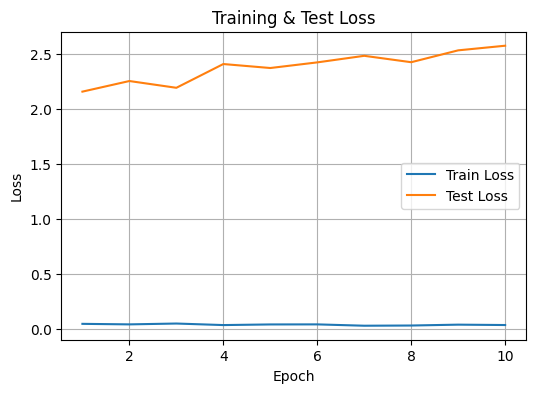

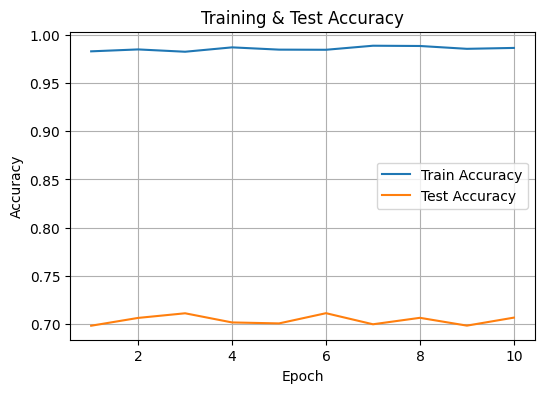

In [13]:
# 3.3b) Tabular output + graphs

import matplotlib.pyplot as plt

# Setup (reuse criterion & optimizer if already defined)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_cifar.parameters(), lr=learning_rate)

# Metric containers
train_losses, train_accs = [], []
test_losses, test_accs   = [], []

# Print header
header = f"{'Epoch':<10}{'Train Loss':<15}{'Train Acc':<15}{'Test Loss':<15}{'Test Acc':<15}"
print(header)
print("-"*len(header))

# Training loop
for epoch in range(1, num_epochs+1):
    tr_loss, tr_acc = train_one_epoch(cnn_cifar, cifar_train_loader, criterion, optimizer, device)
    te_loss, te_acc = evaluate(cnn_cifar, cifar_test_loader, criterion, device)
    
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss);   test_accs.append(te_acc)
    
    # Row print
    print(f"{epoch:<10}{tr_loss:<15.4f}{tr_acc:<15.4f}{te_loss:<15.4f}{te_acc:<15.4f}")

# Plot Loss vs. Epochs
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses,  label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training & Test Loss')
plt.legend(); plt.grid(True)
plt.show()

# Plot Accuracy vs. Epochs
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accs,  label='Test Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training & Test Accuracy')
plt.legend(); plt.grid(True)
plt.show()


Epoch  Train Loss  Train Acc   Test Loss   Test Acc    
-------------------------------------------------------
1      0.2116      0.9378      0.0604      0.9796      
2      0.0530      0.9837      0.0357      0.9881      
3      0.0356      0.9885      0.0381      0.9875      
4      0.0270      0.9911      0.0347      0.9878      
5      0.0221      0.9929      0.0318      0.9900      
6      0.0162      0.9948      0.0308      0.9912      
7      0.0147      0.9951      0.0324      0.9900      
8      0.0105      0.9966      0.0304      0.9911      
9      0.0093      0.9970      0.0351      0.9899      
10     0.0093      0.9969      0.0339      0.9899      


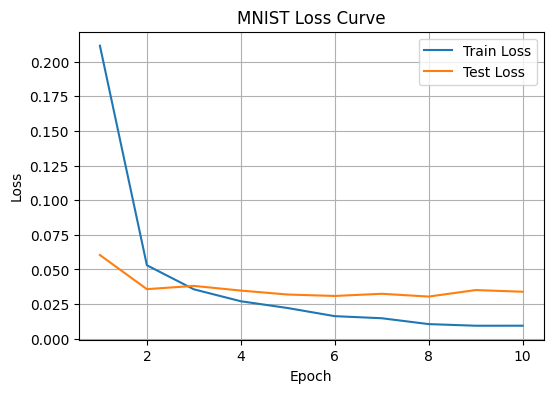

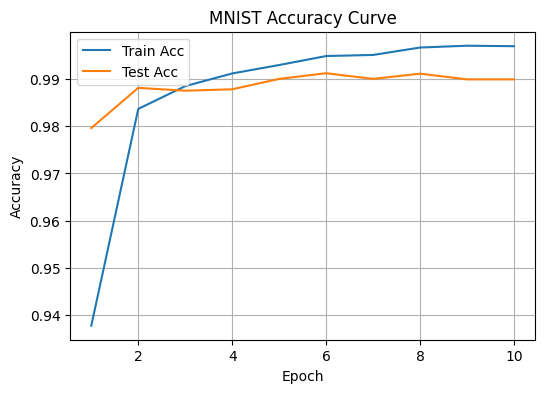

In [14]:
# ▶ Step 3 (MNIST): Train SimpleCNN on the MNIST dataset

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# 1) Loss & optimizer for MNIST
criterion_mnist = nn.CrossEntropyLoss()
optimizer_mnist = optim.Adam(cnn_mnist.parameters(), lr=learning_rate)

# 2) Metric containers
mnist_train_losses, mnist_train_accs = [], []
mnist_test_losses,  mnist_test_accs  = [], []

# 3) Print header
header = f"{'Epoch':<7}{'Train Loss':<12}{'Train Acc':<12}{'Test Loss':<12}{'Test Acc':<12}"
print(header)
print("-" * len(header))

# 4) Training loop
for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(cnn_mnist, mnist_train_loader, criterion_mnist, optimizer_mnist, device)
    te_loss, te_acc = evaluate   (cnn_mnist, mnist_test_loader,  criterion_mnist, device)
    
    mnist_train_losses.append(tr_loss)
    mnist_train_accs.append(tr_acc)
    mnist_test_losses.append(te_loss)
    mnist_test_accs.append(te_acc)
    
    print(f"{epoch:<7}{tr_loss:<12.4f}{tr_acc:<12.4f}{te_loss:<12.4f}{te_acc:<12.4f}")

# 5) Plot Loss
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), mnist_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), mnist_test_losses,  label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('MNIST Loss Curve')
plt.legend(); plt.grid(True); plt.show()

# 6) Plot Accuracy
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), mnist_train_accs, label='Train Acc')
plt.plot(range(1, num_epochs+1), mnist_test_accs,  label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('MNIST Accuracy Curve')
plt.legend(); plt.grid(True); plt.show()


SimpleCNN on CIFAR-10
------------------------------
Accuracy       : 0.7067
Training time  : 117.61 seconds
Inference time : 2.06 seconds


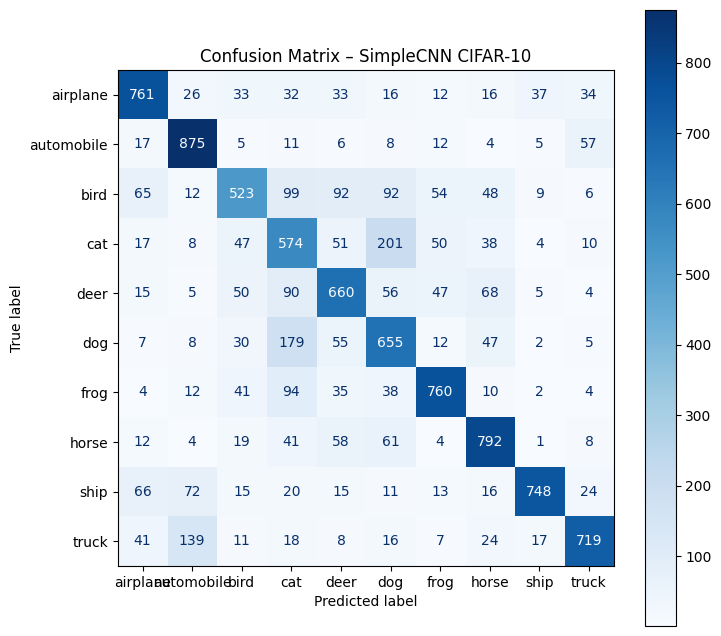

In [16]:
# ────────────────────────────────────────────────────────────
# Evaluation of SimpleCNN on CIFAR-10
# ────────────────────────────────────────────────────────────

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Measure total training time (wrap around your training loop)
start_train = time.time()
# ── re-run your 10-epoch training here ──
for epoch in range(1, num_epochs+1):
    _ = train_one_epoch(cnn_cifar, cifar_train_loader, criterion, optimizer, device)
end_train = time.time()
training_time = end_train - start_train

# 2) Inference time + collect predictions
cnn_cifar.eval()
all_preds, all_labels = [], []
start_inf = time.time()
with torch.no_grad():
    for imgs, labels in cifar_test_loader:
        imgs = imgs.to(device)
        outputs = cnn_cifar(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
end_inf = time.time()
inference_time = end_inf - start_inf

# 3) Compute test accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

# 4) Print metrics
print(f"SimpleCNN on CIFAR-10")
print(f"{'-'*30}")
print(f"Accuracy       : {accuracy:.4f}")
print(f"Training time  : {training_time:.2f} seconds")
print(f"Inference time : {inference_time:.2f} seconds")

# 5) Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cifar_test_loader.dataset.classes)
plt.figure(figsize=(8,8))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix – SimpleCNN CIFAR-10")
plt.show()


SimpleCNN on MNIST
------------------------------
Accuracy       : 0.9903
Training time  : 121.72 seconds
Inference time : 1.75 seconds


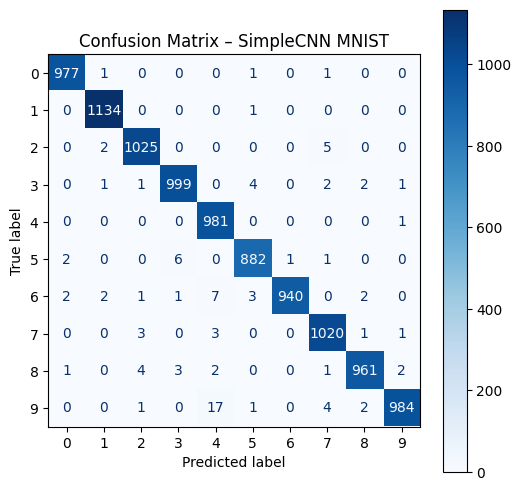

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ────────────────────────────────────────────────────────────
# Evaluation of SimpleCNN on MNIST
# ────────────────────────────────────────────────────────────

# 1) Measure total training time (wrap around your training loop)
start_train = time.time()
for epoch in range(1, num_epochs + 1):
    _ = train_one_epoch(cnn_mnist, mnist_train_loader, criterion_mnist, optimizer_mnist, device)
end_train = time.time()
training_time = end_train - start_train

# 2) Inference time + collect predictions
cnn_mnist.eval()
all_preds, all_labels = [], []
start_inf = time.time()
with torch.no_grad():
    for imgs, labels in mnist_test_loader:
        imgs = imgs.to(device)
        outputs = cnn_mnist(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
end_inf = time.time()
inference_time = end_inf - start_inf

# 3) Compute test accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

# 4) Print metrics
print(f"SimpleCNN on MNIST")
print(f"{'-'*30}")
print(f"Accuracy       : {accuracy:.4f}")
print(f"Training time  : {training_time:.2f} seconds")
print(f"Inference time : {inference_time:.2f} seconds")

# 5) Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(10)))
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix – SimpleCNN MNIST")
plt.show()


# Architecture B – AlexNet

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet CIFAR-10 Epoch 1/10  Train: loss=0.7271, acc=0.7462  Test: loss=0.5601, acc=0.8082
AlexNet CIFAR-10 Epoch 2/10  Train: loss=0.5406, acc=0.8134  Test: loss=0.4933, acc=0.8303
AlexNet CIFAR-10 Epoch 3/10  Train: loss=0.4673, acc=0.8374  Test: loss=0.4484, acc=0.8510
AlexNet CIFAR-10 Epoch 4/10  Train: loss=0.4278, acc=0.8533  Test: loss=0.4241, acc=0.8536
AlexNet CIFAR-10 Epoch 5/10  Train: loss=0.3910, acc=0.8639  Test: loss=0.4406, acc=0.8497
AlexNet CIFAR-10 Epoch 6/10  Train: loss=0.3570, acc=0.8782  Test: loss=0.4231, acc=0.8584
AlexNet CIFAR-10 Epoch 7/10  Train: loss=0.3290, acc=0.8872  Test: loss=0.4244, acc=0.8589
AlexNet CIFAR-10 Epoch 8/10  Train: loss=0.3088, acc=0.8933  Test: loss=0.4040, acc=0.8688
AlexNet CIFAR-10 Epoch 9/10  Train: loss=0.2920, acc=0.8989  Test: loss=0.3971, acc=0.8700
AlexNet CIFAR-10 Epoch 10/10  Train: loss=0.2680, acc=0.9090  Test: loss=0.4194, acc=0.8664

AlexNet CIFAR-10 Final Metrics:
Accuracy       : 0.8664
Training Time  : 1153.66s
Infere

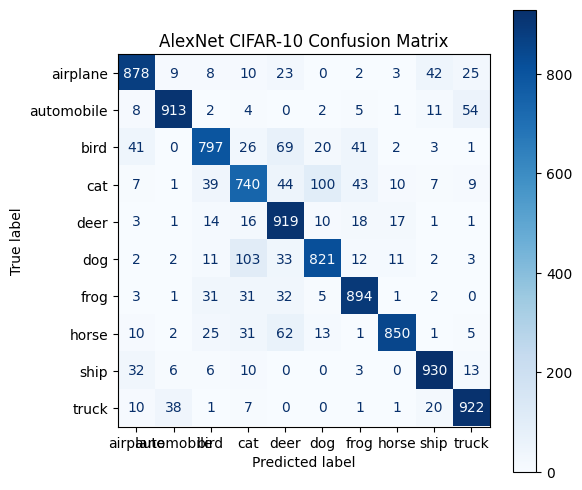

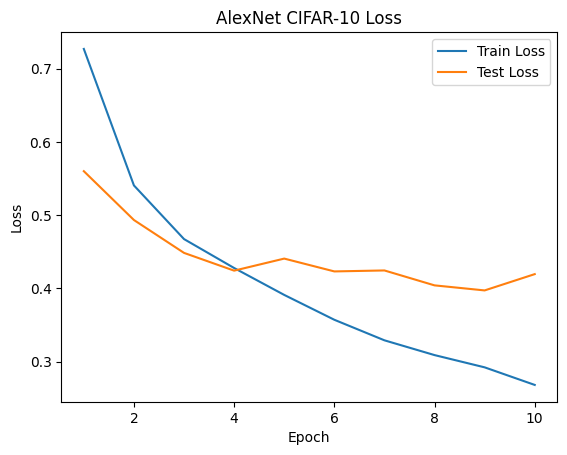

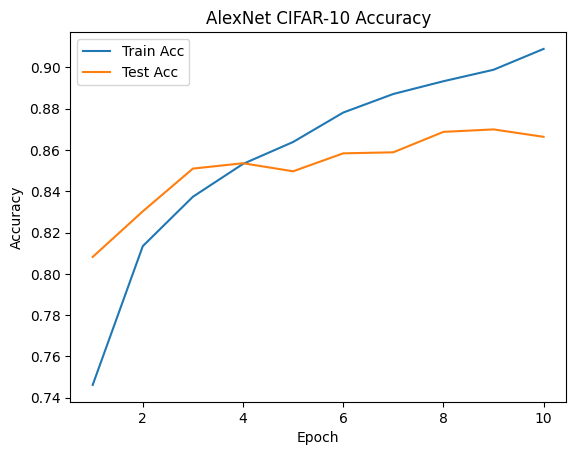

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet MNIST Epoch 1/10  Train: loss=0.1532, acc=0.9551  Test: loss=0.0393, acc=0.9875
AlexNet MNIST Epoch 2/10  Train: loss=0.0784, acc=0.9785  Test: loss=0.0591, acc=0.9830
AlexNet MNIST Epoch 3/10  Train: loss=0.0790, acc=0.9787  Test: loss=0.0442, acc=0.9865
AlexNet MNIST Epoch 4/10  Train: loss=0.0648, acc=0.9828  Test: loss=0.0434, acc=0.9870
AlexNet MNIST Epoch 5/10  Train: loss=0.0697, acc=0.9822  Test: loss=0.0353, acc=0.9896
AlexNet MNIST Epoch 6/10  Train: loss=0.0628, acc=0.9839  Test: loss=0.0414, acc=0.9879
AlexNet MNIST Epoch 7/10  Train: loss=0.0541, acc=0.9860  Test: loss=0.0304, acc=0.9915
AlexNet MNIST Epoch 8/10  Train: loss=0.0490, acc=0.9868  Test: loss=0.0379, acc=0.9895
AlexNet MNIST Epoch 9/10  Train: loss=0.0476, acc=0.9879  Test: loss=0.0274, acc=0.9929
AlexNet MNIST Epoch 10/10  Train: loss=0.0473, acc=0.9879  Test: loss=0.0360, acc=0.9906

AlexNet MNIST Final Metrics:
Accuracy       : 0.9906
Training Time  : 1313.15s
Inference Time : 16.98s


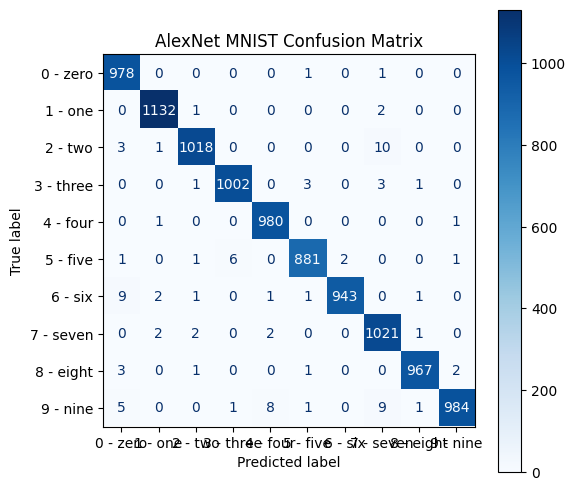

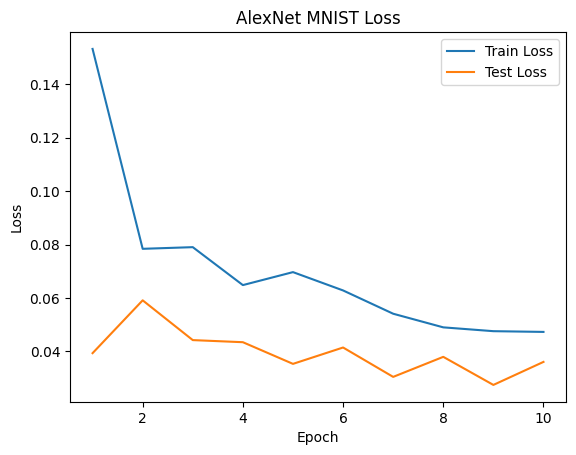

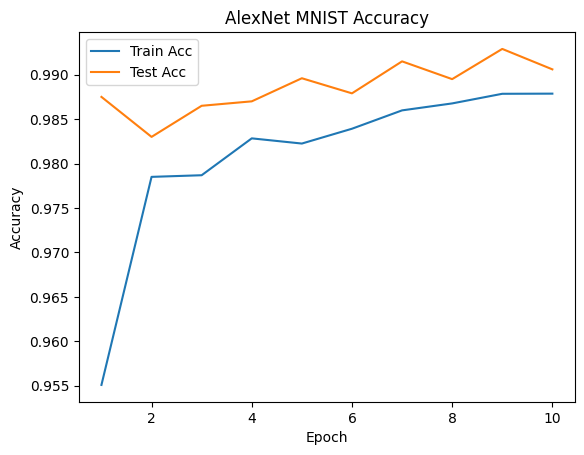

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ─────────────────────────────────────────────────────────────────────────────
# Architecture B: Fine-tune AlexNet on CIFAR-10 and MNIST
# ─────────────────────────────────────────────────────────────────────────────

# 1) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2) Define ImageNet transforms for AlexNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# CIFAR-10: Resize to 224×224, normalize
alex_transform_cifar = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# MNIST: Resize to 224×224, convert to 3 channels, normalize
alex_transform_mnist = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# 3) Data loading
batch_size = 128

# CIFAR-10 loaders
cifar_train = datasets.CIFAR10(root='data', train=True,  download=True, transform=alex_transform_cifar)
cifar_test  = datasets.CIFAR10(root='data', train=False, download=True, transform=alex_transform_cifar)
cifar_train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_test_loader  = DataLoader(cifar_test,  batch_size=batch_size, shuffle=False)

# MNIST loaders
mnist_train = datasets.MNIST(root='data', train=True,  download=True, transform=alex_transform_mnist)
mnist_test  = datasets.MNIST(root='data', train=False, download=True, transform=alex_transform_mnist)
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test,  batch_size=batch_size, shuffle=False)

# 4) Load and adapt AlexNet
def get_alexnet():
    model = models.alexnet(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    return model.to(device)

# 5) Training/evaluation helpers
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# 6) Run training and evaluation
def run_alexnet_experiment(train_loader, test_loader, title):
    model = get_alexnet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    num_epochs = 10

    train_losses, train_accs = [], []
    test_losses, test_accs   = [], []

    start_train = time.time()
    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        te_loss, te_acc = evaluate(model, test_loader, criterion, device)
        train_losses.append(tr_loss); train_accs.append(tr_acc)
        test_losses.append(te_loss); test_accs.append(te_acc)
        print(f"{title} Epoch {epoch}/{num_epochs}  Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}  "
              f"Test: loss={te_loss:.4f}, acc={te_acc:.4f}")
    training_time = time.time() - start_train

    model.eval()
    all_preds, all_labels = [], []
    start_inf = time.time()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds); all_labels.extend(labels.numpy())
    inference_time = time.time() - start_inf

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n{title} Final Metrics:")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Training Time  : {training_time:.2f}s")
    print(f"Inference Time : {inference_time:.2f}s")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    plt.figure(figsize=(6,6))
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f"{title} Confusion Matrix")
    plt.show()

    # Loss & Accuracy plots
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses,  label='Test Loss')
    plt.title(f"{title} Loss"); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Acc')
    plt.plot(range(1, num_epochs+1), test_accs,  label='Test Acc')
    plt.title(f"{title} Accuracy"); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# Run experiments
run_alexnet_experiment(cifar_train_loader, cifar_test_loader, "AlexNet CIFAR-10")
run_alexnet_experiment(mnist_train_loader, mnist_test_loader, "AlexNet MNIST")



# Architecture C – Patch-based LSTM

Running on device: cuda
PatchLSTM CIFAR-10 Epoch 1/10  Train: loss=2.1427, acc=0.3179  Test:  loss=2.0806, acc=0.3771
PatchLSTM CIFAR-10 Epoch 2/10  Train: loss=2.0724, acc=0.3849  Test:  loss=2.0542, acc=0.4072
PatchLSTM CIFAR-10 Epoch 3/10  Train: loss=2.0418, acc=0.4174  Test:  loss=2.0364, acc=0.4230
PatchLSTM CIFAR-10 Epoch 4/10  Train: loss=2.0196, acc=0.4402  Test:  loss=2.0151, acc=0.4464
PatchLSTM CIFAR-10 Epoch 5/10  Train: loss=2.0010, acc=0.4607  Test:  loss=2.0047, acc=0.4551
PatchLSTM CIFAR-10 Epoch 6/10  Train: loss=1.9861, acc=0.4746  Test:  loss=1.9976, acc=0.4611
PatchLSTM CIFAR-10 Epoch 7/10  Train: loss=1.9715, acc=0.4915  Test:  loss=1.9863, acc=0.4719
PatchLSTM CIFAR-10 Epoch 8/10  Train: loss=1.9577, acc=0.5044  Test:  loss=1.9848, acc=0.4750
PatchLSTM CIFAR-10 Epoch 9/10  Train: loss=1.9461, acc=0.5180  Test:  loss=1.9791, acc=0.4808
PatchLSTM CIFAR-10 Epoch 10/10  Train: loss=1.9350, acc=0.5296  Test:  loss=1.9777, acc=0.4820

PatchLSTM CIFAR-10 Final Metrics
-

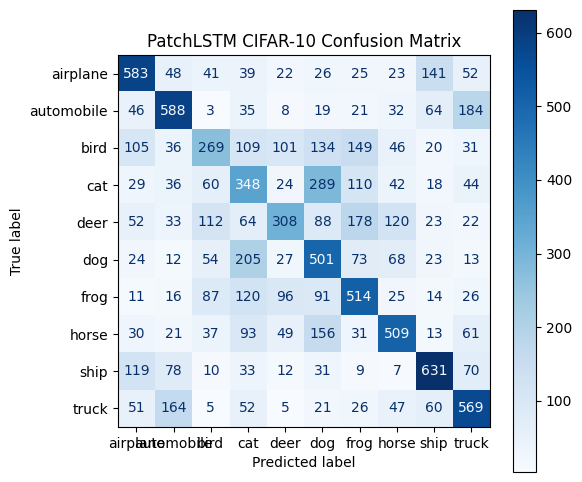

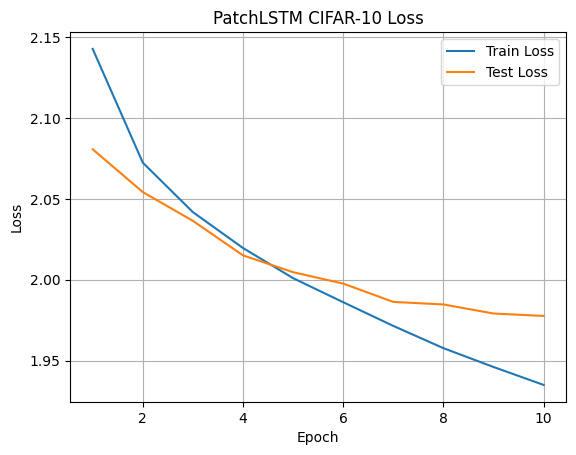

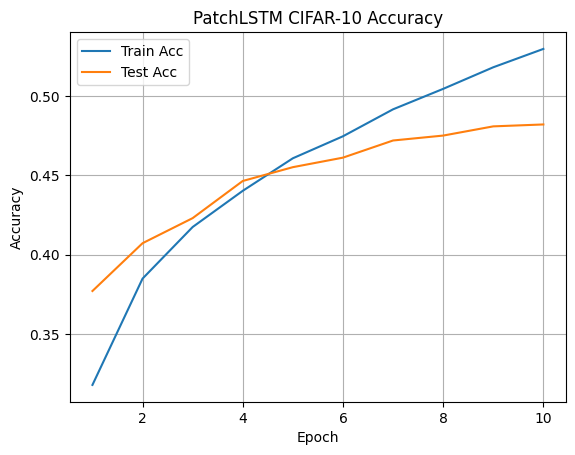

PatchLSTM MNIST Epoch 1/10  Train: loss=1.8349, acc=0.6360  Test:  loss=1.6594, acc=0.8110
PatchLSTM MNIST Epoch 2/10  Train: loss=1.5775, acc=0.8909  Test:  loss=1.5545, acc=0.9115
PatchLSTM MNIST Epoch 3/10  Train: loss=1.5343, acc=0.9304  Test:  loss=1.5272, acc=0.9373
PatchLSTM MNIST Epoch 4/10  Train: loss=1.5204, acc=0.9435  Test:  loss=1.5138, acc=0.9490
PatchLSTM MNIST Epoch 5/10  Train: loss=1.5107, acc=0.9527  Test:  loss=1.5223, acc=0.9416
PatchLSTM MNIST Epoch 6/10  Train: loss=1.5025, acc=0.9603  Test:  loss=1.5072, acc=0.9555
PatchLSTM MNIST Epoch 7/10  Train: loss=1.4994, acc=0.9630  Test:  loss=1.4973, acc=0.9650
PatchLSTM MNIST Epoch 8/10  Train: loss=1.4968, acc=0.9656  Test:  loss=1.4980, acc=0.9639
PatchLSTM MNIST Epoch 9/10  Train: loss=1.4947, acc=0.9677  Test:  loss=1.5007, acc=0.9615
PatchLSTM MNIST Epoch 10/10  Train: loss=1.4916, acc=0.9706  Test:  loss=1.4979, acc=0.9649

PatchLSTM MNIST Final Metrics
------------------------------
Accuracy       : 0.9649
Tra

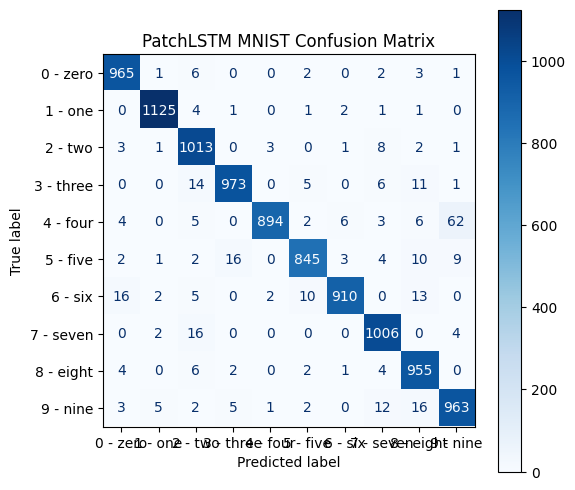

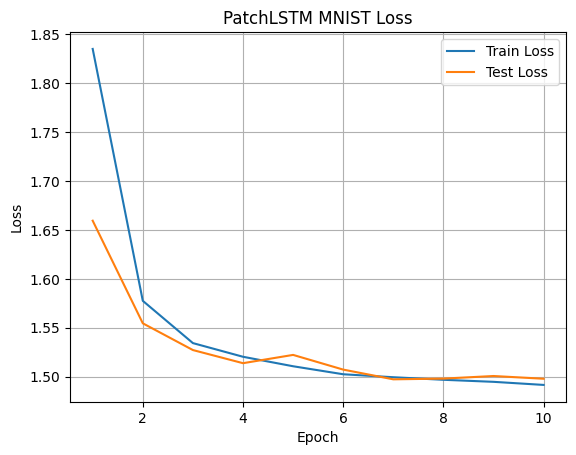

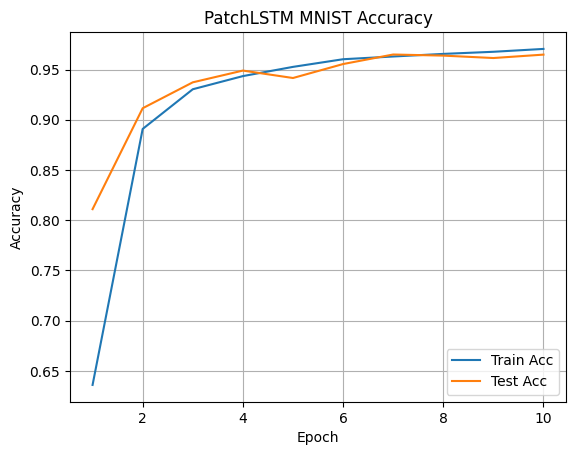

In [21]:
# ─────────────────────────────────────────────────────────────────────────────
# Architecture C – Patch-based LSTM: Full Training & Evaluation Script
# ─────────────────────────────────────────────────────────────────────────────
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Device & Hyperparameters
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size  = 128
num_epochs  = 10
learning_rate = 1e-3

# Patch settings
patch_size_cifar = 8   # 32×32 → 4×4 grid → 16 patches
patch_size_mnist = 7   # 28×28 → 4×4 grid → 16 patches
hidden_dim = 128
num_layers = 1
num_classes = 10

print(f"Running on device: {device}")

# 2) Data transforms (just tensor + normalize to [-1,1])
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 3) DataLoaders
cifar_train_loader = DataLoader(
    datasets.CIFAR10(root='data', train=True,  download=True, transform=cifar_transform),
    batch_size=batch_size, shuffle=True
)
cifar_test_loader  = DataLoader(
    datasets.CIFAR10(root='data', train=False, download=True, transform=cifar_transform),
    batch_size=batch_size, shuffle=False
)
mnist_train_loader = DataLoader(
    datasets.MNIST(root='data', train=True,  download=True, transform=mnist_transform),
    batch_size=batch_size, shuffle=True
)
mnist_test_loader  = DataLoader(
    datasets.MNIST(root='data', train=False, download=True, transform=mnist_transform),
    batch_size=batch_size, shuffle=False
)

# 4) Helper to extract patches
def img_to_patches(x, patch_size):
    """
    x: (B, C, H, W)
    returns: (B, seq_len, C*patch_size*patch_size)
    """
    # unfold: (B, C*patch_size*patch_size, seq_len)
    patches = F.unfold(x, kernel_size=patch_size, stride=patch_size)
    # shape -> (B, seq_len, patch_dim)
    patches = patches.permute(0, 2, 1)
    return patches

# 5) Patch-LSTM model
class PatchLSTM(nn.Module):
    def __init__(self, in_channels, patch_size, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.input_dim = in_channels * patch_size * patch_size
        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, num_classes),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        # x: (B, C, H, W)
        patches = img_to_patches(x, patch_size=(x.size(2)//(x.size(2)//patch_size_cifar) if x.size(2)==32 else patch_size_mnist))
        # above picks correct patch_size per dataset automatically
        lstm_out, _ = self.lstm(patches)            # (B, seq_len, hidden_dim)
        final_out = lstm_out[:, -1, :]              # (B, hidden_dim)
        return self.classifier(final_out)           # (B, num_classes)

# 6) Training & evaluation helpers
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

# 7) Experiment runner
def run_patchlstm_experiment(model, train_loader, test_loader, title):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, train_accs = [], []
    test_losses,  test_accs  = [], []

    # a) Training
    t0 = time.time()
    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        te_loss, te_acc = evaluate(model, test_loader, criterion, device)
        train_losses.append(tr_loss); train_accs.append(tr_acc)
        test_losses.append(te_loss);   test_accs.append(te_acc)
        print(f"{title} Epoch {epoch}/{num_epochs}  "
              f"Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}  "
              f"Test:  loss={te_loss:.4f}, acc={te_acc:.4f}")
    training_time = time.time() - t0

    # b) Inference & confusion matrix
    model.eval()
    all_preds, all_labels = [], []
    t1 = time.time()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outs = model(imgs)
            preds = outs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    inference_time = time.time() - t1
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    print(f"\n{title} Final Metrics")
    print("-"*30)
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Training Time  : {training_time:.2f} s")
    print(f"Inference Time : {inference_time:.2f} s")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    plt.figure(figsize=(6,6))
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f"{title} Confusion Matrix")
    plt.show()

    # Loss & Accuracy curves
    plt.figure()
    plt.plot(range(1,num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1,num_epochs+1), test_losses,  label='Test Loss')
    plt.title(f'{title} Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(range(1,num_epochs+1), train_accs, label='Train Acc')
    plt.plot(range(1,num_epochs+1), test_accs,  label='Test Acc')
    plt.title(f'{title} Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.show()

# 8) Instantiate & run
model_cifar = PatchLSTM(in_channels=3, patch_size=patch_size_cifar,
                        hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)
model_mnist= PatchLSTM(in_channels=1, patch_size=patch_size_mnist,
                        hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)

run_patchlstm_experiment(model_cifar, cifar_train_loader, cifar_test_loader, "PatchLSTM CIFAR-10")
run_patchlstm_experiment(model_mnist, mnist_train_loader, mnist_test_loader, "PatchLSTM MNIST")


# Comparitive